In [137]:
%matplotlib inline
import sys, os, glob

from astropy.io import fits, ascii

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from astropy import units as u
from astropy.table import Table
import astropy.constants as const
from astropy.coordinates import SkyCoord, concatenate
from astropy import table

from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

import scipy.stats as st
from scipy.optimize import minimize
from scipy.integrate import trapezoid, cumulative_trapezoid

import emcee
import corner

In [138]:
import scienceplots

plt.style.use(['science', 'no-latex', 'notebook', 'light'])

In [139]:
def f_BHOF(x, x0, delta=1, theta=2.5):
    # Occupation function 
    #return 1/2*(1 + np.tanh(2.5**np.abs(8.9 - x0) * (x - x0))) # (Miller 2015)
    return 1/(1 + delta * np.exp(-theta*(x - x0)))**(1/delta)

In [169]:
def log_likelihood(theta, x, y, xerr, yerr):
    
    # parameters to be fit
    log_ms0, log_lam_min, delta1, log_f = theta

    log_lam_min = -6
    # TODO: can try to infer log_lam_min, but probably need to get the initial condition set close

    log_lam = y + 1 - 38.2 - (x - 4)
    lam = 10**loglam
    lam_min = 10**log_lam_min

    dlogl = .01
    log_lam_eval = np.arange(log_lam_min, 10, dlogl)
    lam_eval = 10**log_lam_eval
    dlam_eval = np.diff(lam_eval)

    mask_det = yerr > 0

    s2 = np.full(len(mask_det), np.exp(2*log_f)**2 + (xerr)**2)
    s2[mask_det] = yerr[mask_det]**2 + np.exp(2*log_f)**2 + (xerr[mask_det])**2

    if np.min(loglam[mask_det]) < log_lam_min:
        return -np.inf

    # p = f * N + (1 - p) delta 
    _f_BHOF = f_BHOF(x, log_ms0)
    
    # pdf
    alpha = delta1 + 1 # > must be 1
    ### WORKING THING: pdf_pl = (alpha-1) * lam_min**(alpha-1) * lam**-alpha # TODO: add the other power-law term

    pdf_pl = (alpha-1) * lam_min**(alpha-1) * lam_eval**-alpha
    pdf_norm = st.norm.pdf(log_lam[mask_det, np.newaxis] - log_lam_eval, scale=np.sqrt(s2[mask_det, np.newaxis]))
    pdf = trapezoid(pdf_pl * pdf_norm, dx=dlam_eval, axis=1)

    # Integral of pdf
    #Neval = (alpha-1) * lam_min**(alpha-1) * lam_eval**-alpha
    
    # data axis, convolve axis, int axis
    log_lam_int = log_lam_eval - np.max(log_lam_eval) + log_lam[~mask_det, np.newaxis]
    dlam_int = dlam_eval

    #pdf_norm_int = st.norm.pdf(log_lam_int[:, :, np.newaxis] - log_lam_eval, scale=np.sqrt(s2[~mask_det, np.newaxis, np.newaxis]))
    #pdf_int = trapezoid(pdf_pl * pdf_norm_int, dx=dlam_eval, axis=2)

    pdf_norm_int = st.norm.pdf(log_lam_eval[:, np.newaxis] - log_lam_eval, scale=np.sqrt(np.mean(s2[~mask_det])))
    pdf_int = trapezoid(pdf_pl * pdf_norm_int, dx=dlam_eval, axis=1)

    pdf_int[log_lam_eval < log_lam_min] = 0.0
    cdf = cumulative_trapezoid(pdf_int, dx=dlam_int)
    #print(np.shape(cdf))
    #print(np.shape(log_lam_eval))
    # Not that much faster, but more memory friendly
    cdf = np.interp(log_lam[~mask_det], log_lam_eval[1:], cdf)

    #pdf_int[:, np.where(log_lam_int < log_lam_min)[0]] = 0.0
    #cdf = trapezoid(pdf_int, dx=dlam_int, axis=1)
    
    p_det = _f_BHOF[mask_det] * pdf # second term is zero for detected sources
    p_cens = _f_BHOF[~mask_det] * cdf + (1 - _f_BHOF[~mask_det])
    
    # Total likelihood
    ll = np.sum(np.log(p_det)) + np.sum(np.log(p_cens))
    
    return ll

def log_likelihood_lognorm(theta, x, y, xerr, yerr, xp):
    
    # parameters to be fit
    log_ms0, alpha, beta, log_f = theta

    mask_det = yerr > 0

    # Total model variance
    s2 = np.exp(2*log_f)**2 + (beta*xerr)**2
    s2[mask_det] = yerr[mask_det]**2 + np.exp(2*log_f)**2 + (beta*xerr[mask_det])**2

    # This recovers the slope and scatter perfectly
    N = st.norm.pdf((y - alpha - beta*x), scale=np.sqrt(s2))
    S = st.norm.sf(-(y - alpha - beta*x), scale=np.sqrt(s2)) # This is what I would expect it to be

    # p = f * N + (1 - p) delta 

    _f_BHOF = f_BHOF(x + xp, log_ms0 + xp)
        
    p_det =  _f_BHOF[mask_det] * N[mask_det] # second term is zero for detected sources
    p_cens =  _f_BHOF[~mask_det] * S[~mask_det] + (1 - _f_BHOF[~mask_det])
    
    # Total likelihood
    ll = np.sum(np.log(p_det)) + np.sum(np.log(p_cens))

    return ll

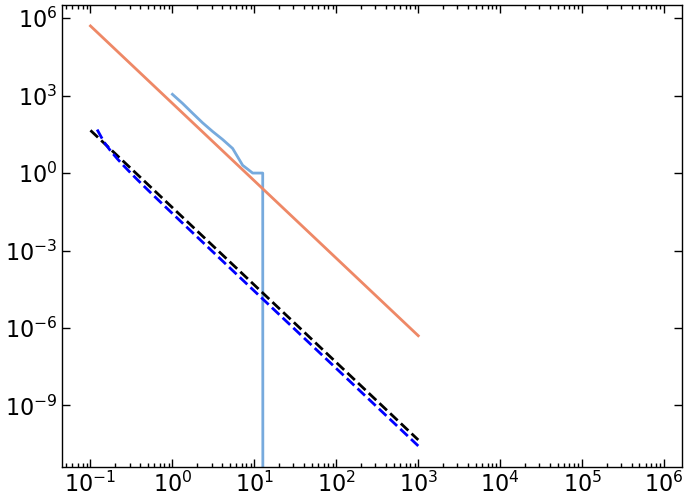

In [170]:
lam_min = 1e-10
delta1 = 3

def pl_rvs(a, b, g, size=1):
    r = np.random.random(size=size)
    ag, bg = a**g, b**g
    return (ag + (bg - ag)*r)**(1./g)

plt.show()
h, b= np.histogram(pl_rvs(1e0, 1e6, -delta1, size=2000), bins=np.logspace(0, 6))
plt.loglog(b[:-1], h)

xx = np.logspace(-1, 3)
dxx = np.diff(xx)
plt.plot(xx, 500*xx**-3)

xx_conv = np.arange(-10, 10, 0.01)
dx = np.diff(xx_conv)

t = (delta1-1) * (1e-6)**(delta1-1) * (10**xx_conv)**-delta1
f = np.trapz( t * st.norm.pdf(np.log10(xx[:,np.newaxis]) - xx_conv, scale=np.sqrt(1)), dx=dx, axis=1)
plt.plot(xx, f, linestyle='dashed', color='k')

plt.plot(xx[1:], f[1:]/np.cumsum(np.interp(xx, xx, f)[1:]*dxx), linestyle='dashed', color='b')


#f = np.trapz(( ((10**np.arange(-10, 10, 0.1)/1e3)**delta1 + (10**np.arange(-10, 10, 0.1)/1e3)**(delta1+1))**-1) * st.norm.pdf(xx[:,np.newaxis] - np.arange(-10, 10, 0.1), scale=np.sqrt(50)), dx=.1, axis=1)
#plt.plot(xx, f, linestyle='dotted')

In [171]:
def log_prior(theta):
    logms0, alpha, beta, log_f = theta
    
    if 5.0 < logms0 < 15.0 and -50 < alpha < 1 and 0.0 < beta < 2.0 and -2.0 < log_f < 1.0:
      return 0.0
    return -np.inf

def log_probability(theta, x, y, xerr, yerr):
    lp = log_prior(theta)
    ll = log_likelihood(theta, x, y, xerr, yerr)
    if not np.isfinite(lp) or not np.isfinite(ll):
        return -np.inf
    return lp + ll

100%|██████████| 300/300 [07:46<00:00,  1.55s/it]


(1280, 4)
95% CI:  5.557676941396061


/var/folders/kx/qz91z8390zqfjrd9v6mt61w00000gn/T/ipykernel_58457/4153527758.py:172: RuntimeWarning: invalid value encountered in divide
  frac_det = hist_det/hist_all


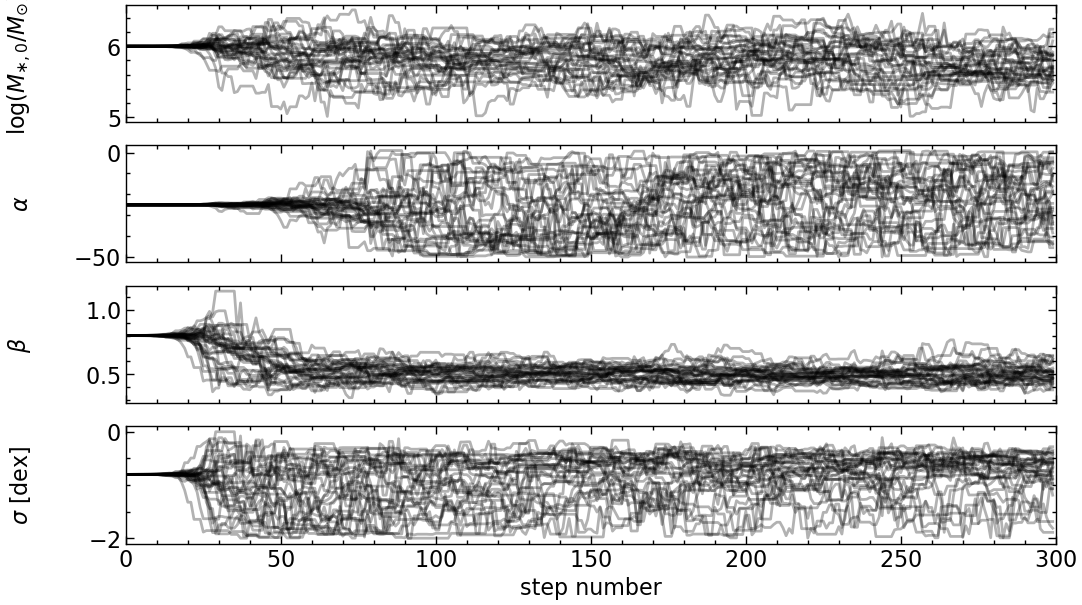

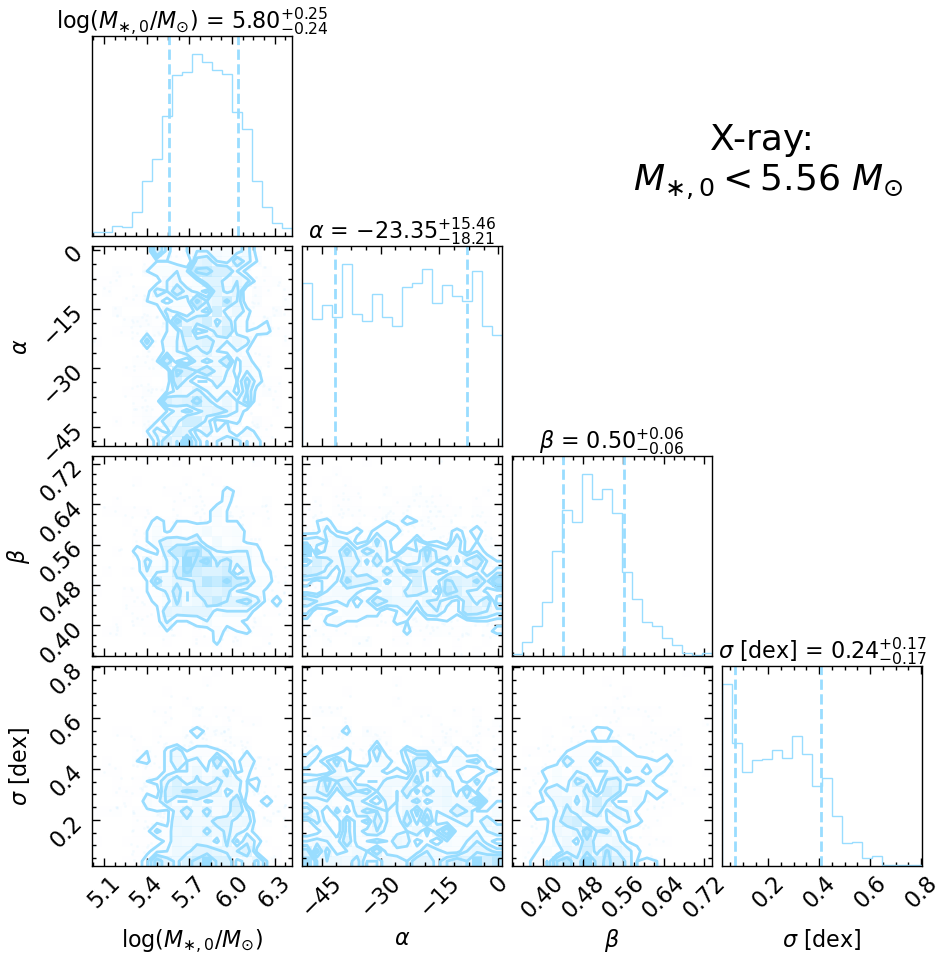

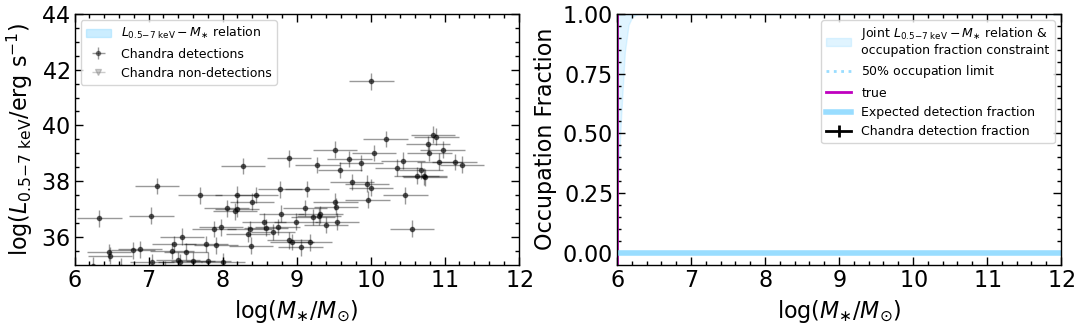

  9%|▉         | 28/300 [00:45<07:26,  1.64s/it]/var/folders/kx/qz91z8390zqfjrd9v6mt61w00000gn/T/ipykernel_58457/3920864995.py:63: RuntimeWarning: invalid value encountered in log
  ll = np.sum(np.log(p_det)) + np.sum(np.log(p_cens))
100%|██████████| 300/300 [08:03<00:00,  1.61s/it]


(1280, 4)
95% CI:  6.863158951894961


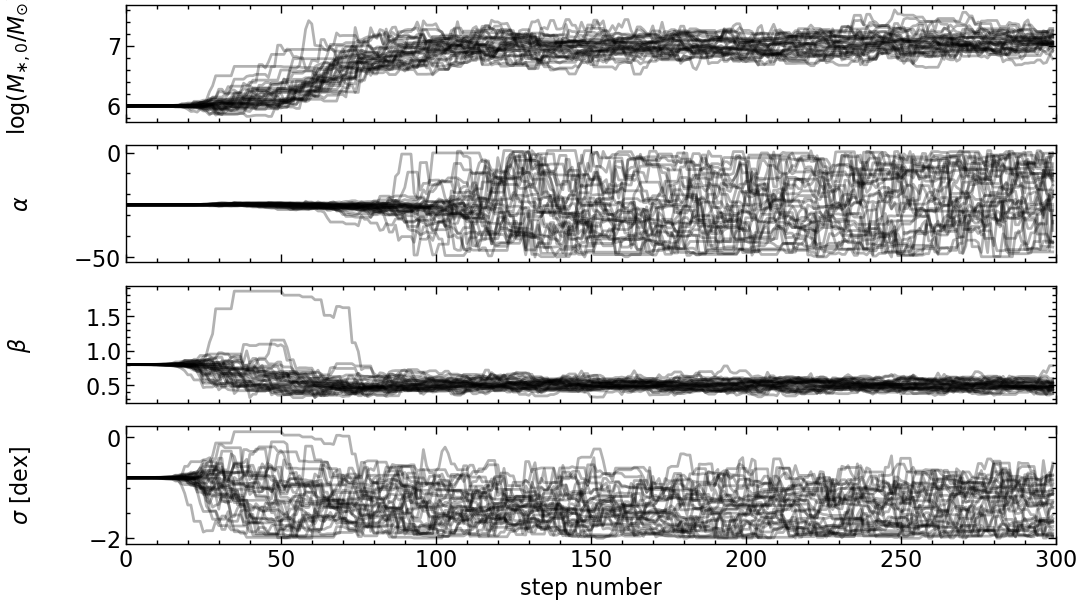

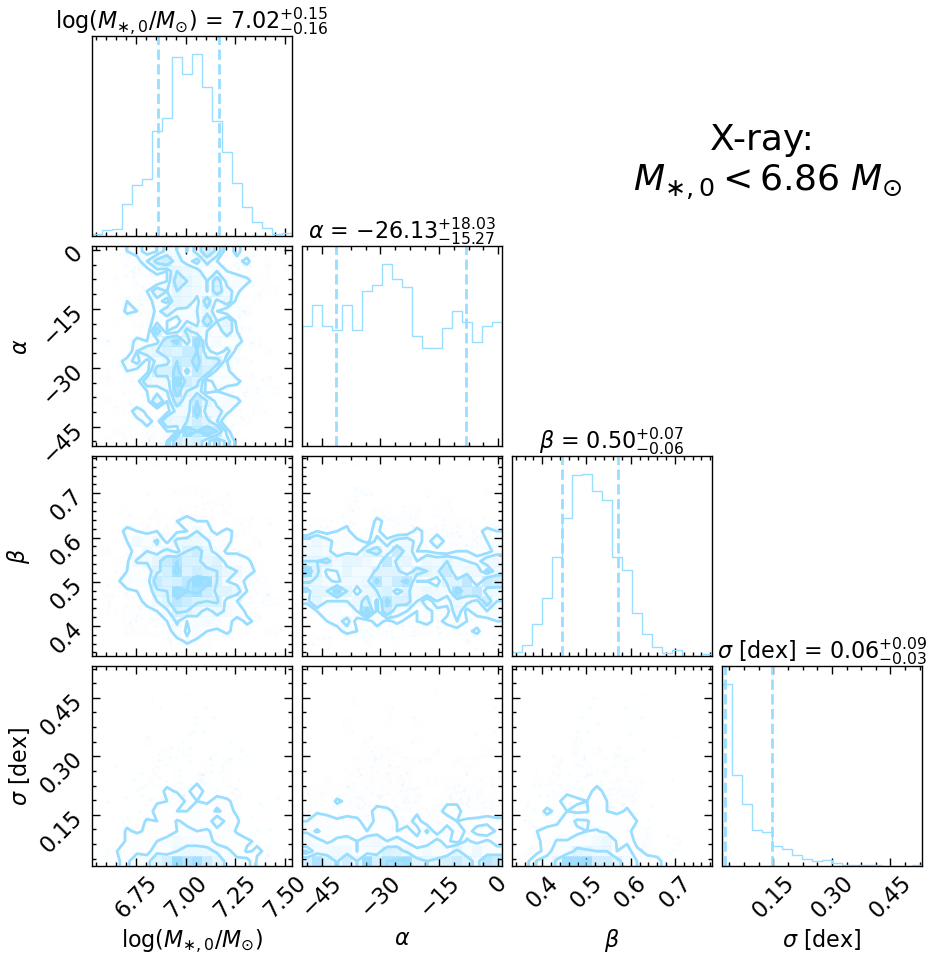

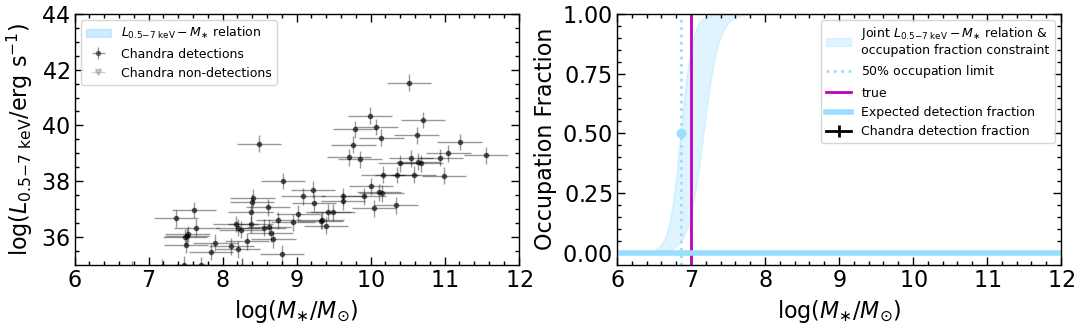

100%|██████████| 300/300 [08:18<00:00,  1.66s/it]


(1280, 4)
95% CI:  7.919604875833514


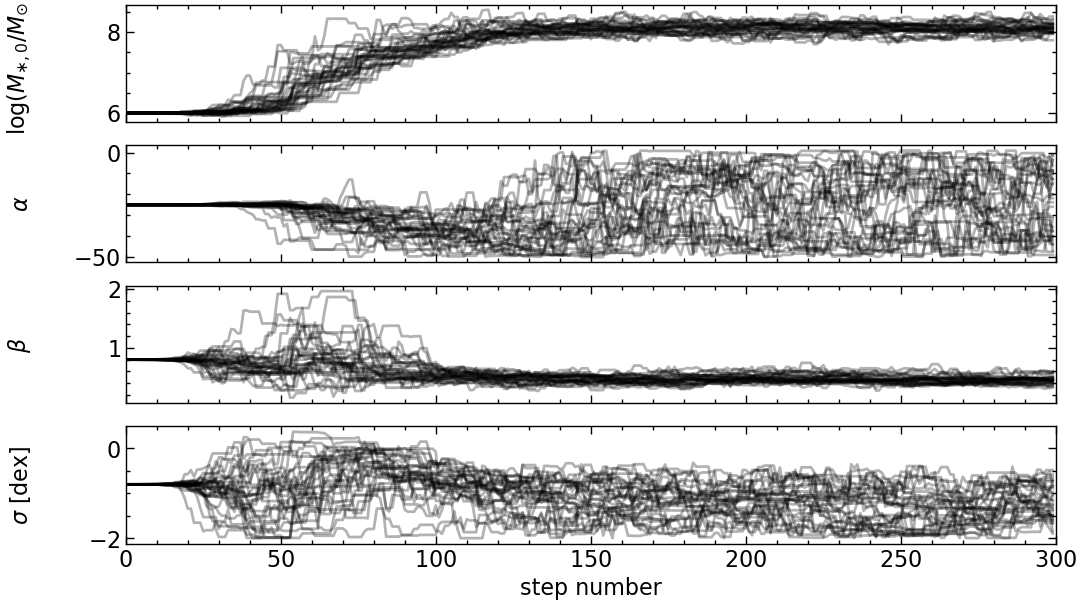

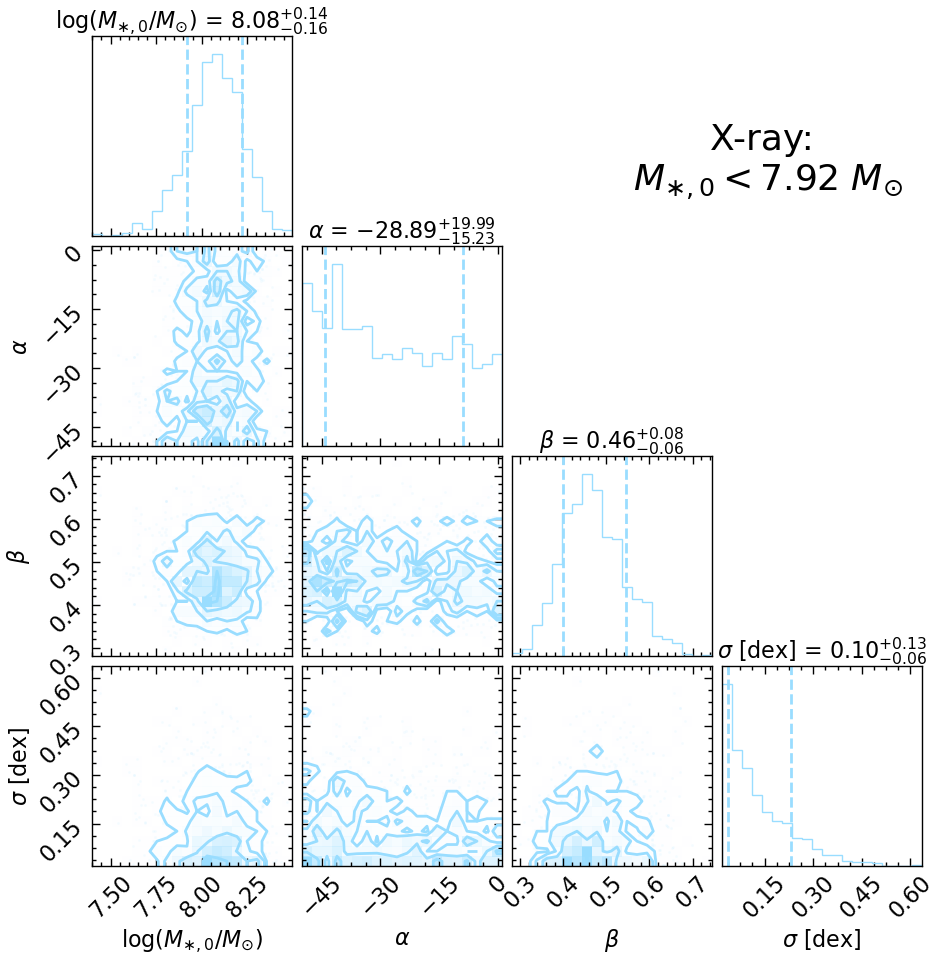

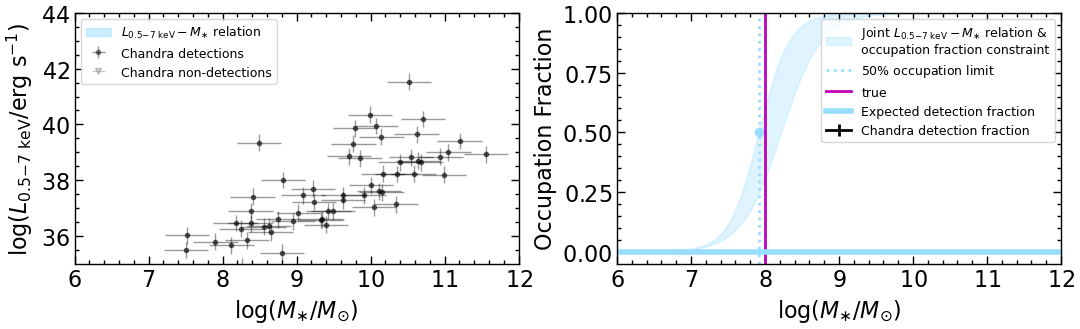

100%|██████████| 300/300 [08:54<00:00,  1.78s/it]


(1280, 4)
95% CI:  8.480622893265345


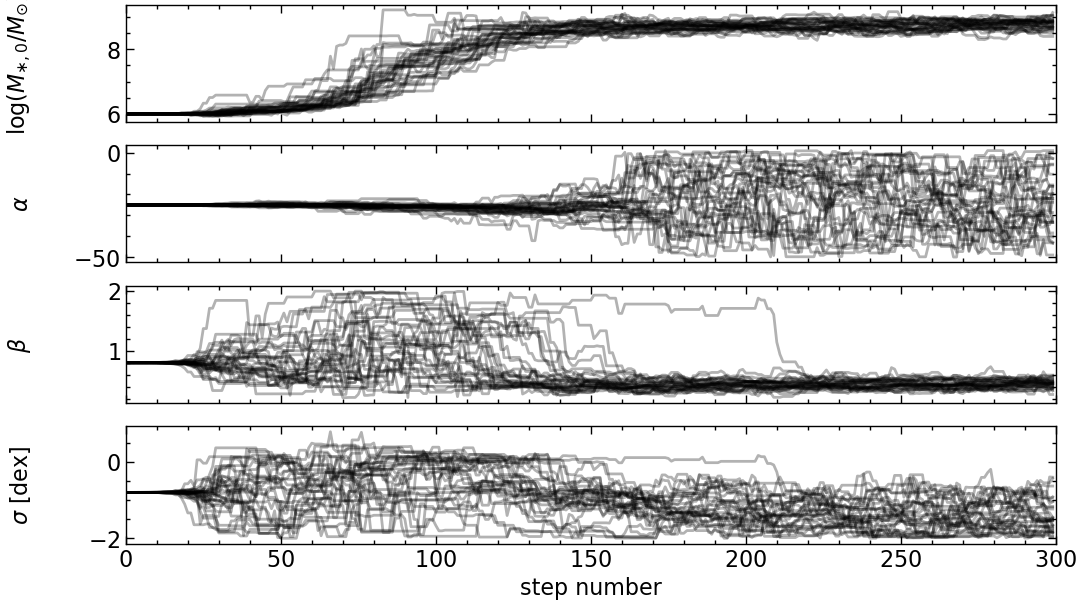

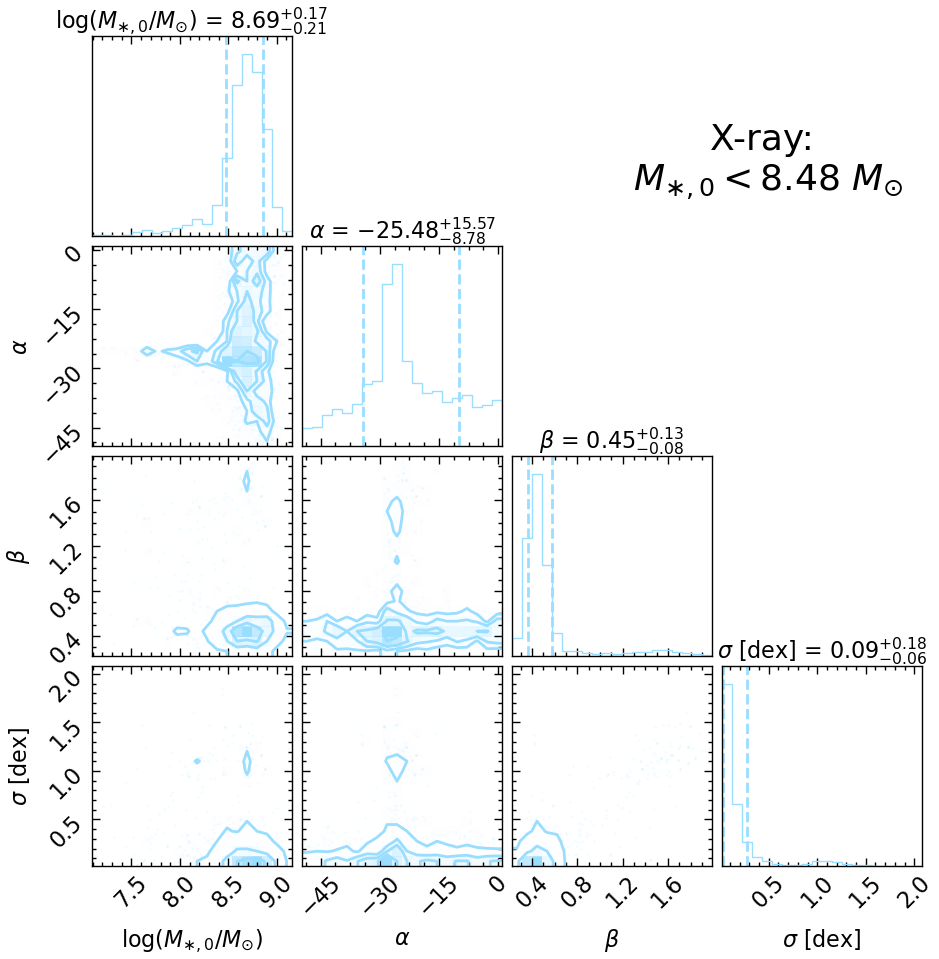

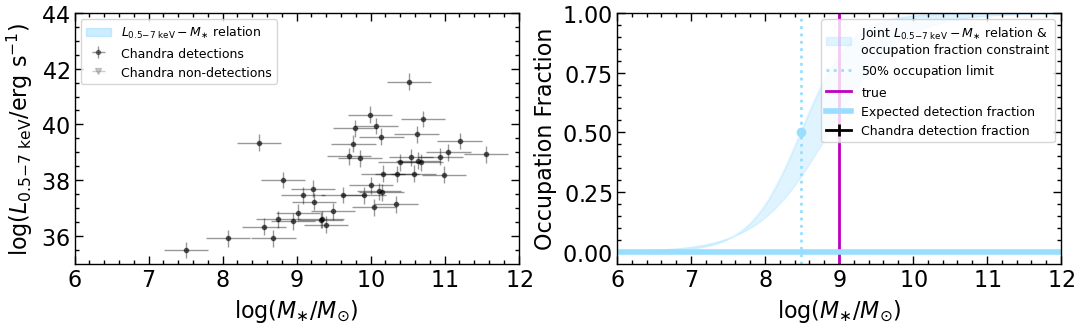

100%|██████████| 300/300 [09:54<00:00,  1.98s/it]


(1280, 4)
95% CI:  9.698682205982184


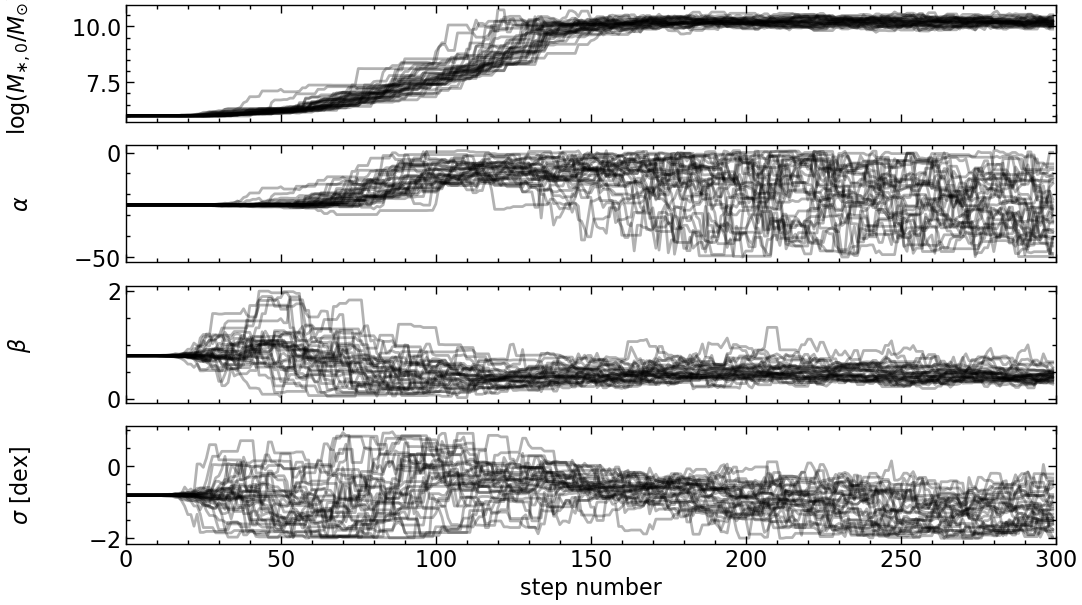

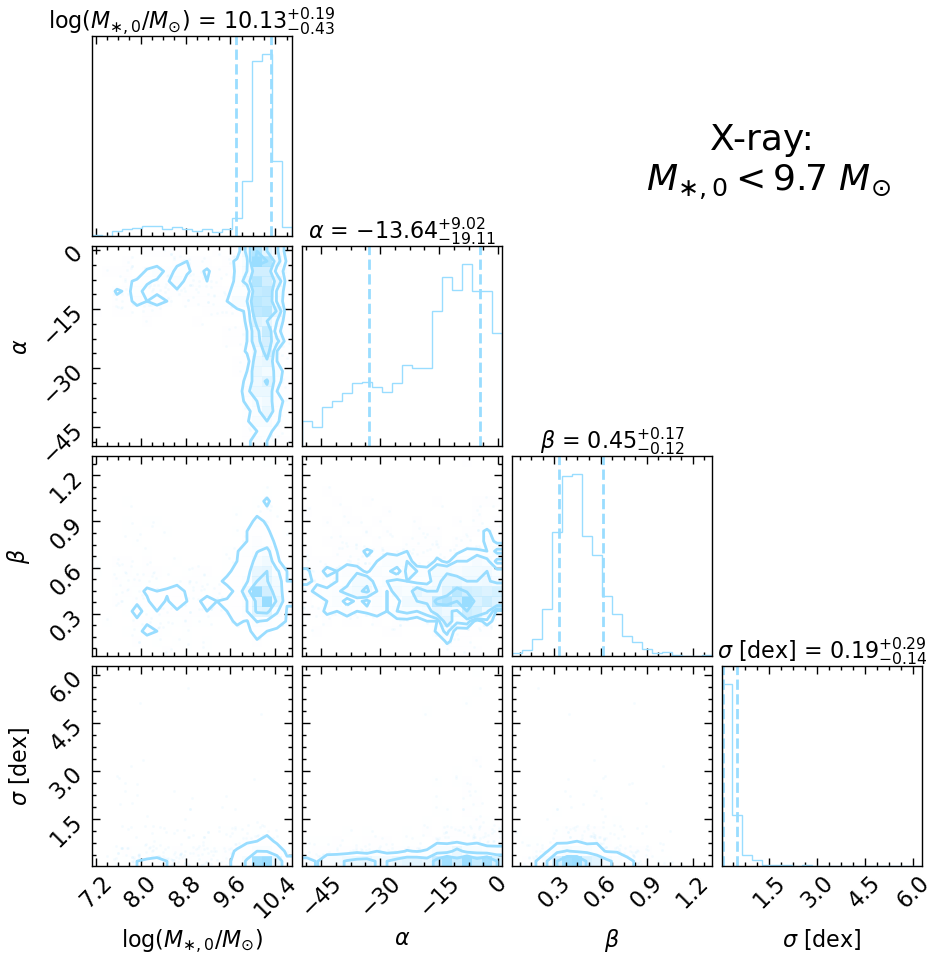

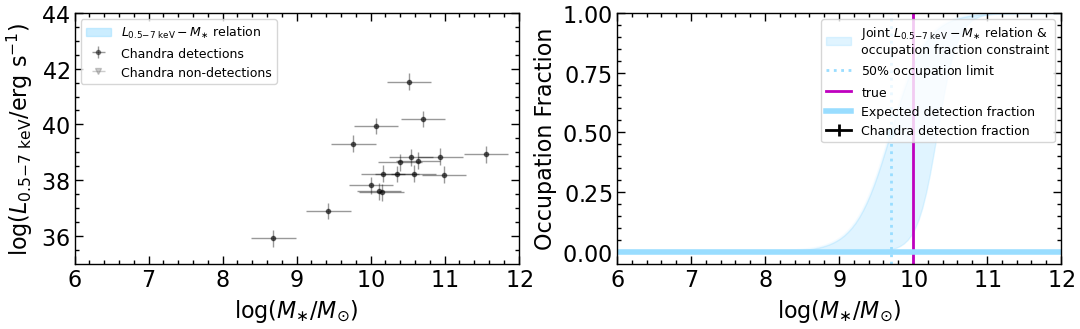

In [172]:
x50_out_lo = []
x50_out_med =[]
x50_out_hi = []

beta_out_lo = []
beta_out_med =[]
beta_out_hi = []

x50_true = np.arange(6, 10.5, 1) # Input

delta1_true = 0.5

for log_x50_i in x50_true: 

    # Draw from p(y | x)
    x = np.linspace(6, 11, 100)

    y = x - 4 + 38.2 - 1

    loglam = np.log10(pl_rvs(1e-6, 1, -delta1_true, size=len(x)))
    
    y = y + loglam

    #y = y + np.random.normal(0.0, .8, size=len(x))
    
    # uncertainties
    xerr = np.full(len(x), 0.3)
    yerr = np.full(len(x), 0.3)

    # I_occ = 1 means BH is there
    # I_occ = 0 means no BH
    I_occ = st.bernoulli.rvs(f_BHOF(x, log_x50_i), size=len(x))

    # Mimic
    x += np.random.normal(0, xerr)
    y += np.random.normal(0, yerr)

    y[I_occ==0] = -9999

    # limiting sensitivity
    y_lim = 18.0

    # Negative error means upper-limit
    mask_lim = (y) < y_lim
    yerr[mask_lim] = -1.0
    y[mask_lim] = y_lim

    ######### ignore below, just running emcee #########

    nsamp=300
    nburn=100
    color='C4'

    np.random.seed(42)

    pos = [6, -25, .8, -0.8] 
    pos = np.array(pos) + 1e-4 * np.random.randn(32, len(pos))
    nwalkers, ndim = pos.shape

    # Sampler
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, xerr, yerr))

    sampler.run_mcmc(pos, nsamp, progress=True);

    # Plot (you can ignore this)

    fig, axes = plt.subplots(ndim, figsize=(12, 7), sharex=True)
    samples = sampler.get_chain()

    labels = [r"$\log(M_{\ast,0}/M_{\odot})$", r"$\alpha$", r"$\beta$", r"$\sigma$ [dex]"]

    for i in range(ndim):
        ax = axes[i]
        ax.plot(samples[:, :, i], "k", alpha=0.3)
        ax.set_xlim(0, len(samples))
        ax.set_ylabel(labels[i])
        ax.yaxis.set_label_coords(-0.1, 0.5)

    axes[-1].set_xlabel("step number");

    #tau = sampler.get_autocorr_time()
    #print(tau)
    # I'm probably not running long enough chain, yeah yeah...

    flat_samples = sampler.get_chain(discard=nburn, thin=5, flat=True)
    print(flat_samples.shape)

    # Medians
    alpha_x50 = np.median(flat_samples[:,1])
    beta_x50 = np.median(flat_samples[:,2])
    sigma50 = np.median(np.exp(2*flat_samples[:,3])) 

    # Corner
    flat_samples[:,3] = np.exp(2*flat_samples[:,3]) # sigma
    #flat_samples[:,0] += xp # log M_*,0
    #flat_samples[:,1] += yp # alpha
    fig_corner = corner.corner(flat_samples, labels=labels, quantiles=[0.16, 0.84], color=color, show_titles=True)

    # TODO::::: Increase the 1st column limit + 1 and use 95th percentile

    fig, axes = plt.subplots(1, 2, figsize=(11, 3.5))

    # Plot data
    x_eval = np.linspace(5, 15, 200)
    axes[0].scatter(x[yerr > 0], y[yerr > 0], marker='.', color='k', alpha=0.2)
    axes[0].errorbar(x[yerr > 0], y[yerr > 0], elinewidth=1,
                        xerr=xerr[yerr > 0], yerr=yerr[yerr > 0],
                        fmt=".k", capsize=0, alpha=0.4, label='Chandra detections')
    # Pick random
    if len(x[yerr < 0]) > 50000:
        ind_rand = np.random.choice(len(x[yerr < 0]), 50, replace=False)
    else:
        ind_rand = np.arange(len(x[yerr < 0]))
    axes[0].errorbar(x[yerr < 0][ind_rand], y[yerr < 0][ind_rand],
                        xerr=xerr[yerr < 0][ind_rand], elinewidth=1, markersize=5,
                        marker="v", linestyle="none", color="gray", alpha=0.4, capsize=0, zorder=-1, label='Chandra non-detections')


    axes[0].legend(fontsize=14)
    axes[0].set_xlim([6, 12])
    axes[0].set_ylim([35, 44])
    axes[0].set_xlabel(r'$\log(M_{\ast} / M_{\odot})$')
    axes[0].set_ylabel(r'$\log(L_{0.5{-}7\ {\rm{keV}}} / {\rm{erg}}\ {\rm{s}}^{-1})$')

    # Linear relation
    relation = np.zeros([len(flat_samples), len(x_eval)])
    for i, s in enumerate(flat_samples):
        relation[i,:] = np.dot(np.vander(x_eval, 2), [s[2], s[1]])

    axes[0].fill_between(x_eval, np.percentile(relation, 84, axis=0), np.percentile(relation, 16, axis=0),
                            color=color, alpha=0.5, zorder=2, label=r'$L_{0.5{-}7\ {\rm{keV}}} - M_{\ast}$ relation')
    axes[0].plot(x_eval, np.percentile(relation, 84, axis=0)+sigma50,
                color=color, alpha=0.8, zorder=2, linestyle='dotted')
    axes[0].plot(x_eval, np.percentile(relation, 16, axis=0)-sigma50,
                color=color, alpha=0.8, zorder=2, linestyle='dotted')

    # Limits
    #mask_outlier = flat_samples[:,0] > np.percentile(flat_samples[:,0], 50)

    log_ms50_low = np.percentile(flat_samples[:,0], 16)
    log_ms50_med = np.percentile(flat_samples[:,0], 50)
    log_ms50_high = np.percentile(flat_samples[:,0], 84)
    print('95% CI: ', log_ms50_low)

    x50_out_lo.append(log_ms50_low)
    x50_out_med.append(log_ms50_med)
    x50_out_hi.append(log_ms50_high)

    # Occupation fraction
    alpha50 = np.median(flat_samples[:,1])
    beta50 = np.median(flat_samples[:,2])
    f_occ_low = 1/2*(1 + np.tanh(2.5**np.abs(8.9 - log_ms50_low) * (x_eval - log_ms50_low)))
    f_occ_high = 1/2*(1 + np.tanh(2.5**np.abs(8.9 - log_ms50_high) * (x_eval - log_ms50_high)))
        
    beta_out_lo.append(np.percentile(flat_samples[:,2], 95))
    beta_out_med.append(np.percentile(flat_samples[:,2], 55))
    beta_out_hi.append(np.percentile(flat_samples[:,2], 5))

    axes[1].plot(x_eval, f_occ_low, color, alpha=0.1)
    axes[1].fill_between(x_eval, f_occ_high,  f_occ_low, color=color, alpha=0.3,
                            label=r'Joint $L_{0.5{-}7\ {\rm{keV}}} - M_{\ast}$ relation &'+'\n'+'occupation fraction constraint')

    # 50% occupation
    axes[1].scatter(log_ms50_low, 0.5, color=color)
    axes[1].axvline(log_ms50_low, linestyle='dotted', color=color, label=r'$50\%$ occupation limit')
        
    axes[1].axvline(log_x50_i, color='m', label=r'true')

    # Histogram
    hist_det, bin_edges = np.histogram(x[yerr>0], bins=np.arange(-3, 3, 0.5))
    hist_all, bin_edges = np.histogram(x,  bins=np.arange(-3, 3, 0.5))
    frac_det = hist_det/hist_all

    bincenter = (bin_edges[:-1] + bin_edges[1:]) / 2

    axes[1].errorbar(bincenter[hist_det>0], frac_det[hist_det>0],
                        yerr=st.binom.std(hist_all[hist_det>0], frac_det[hist_det>0])/hist_all[hist_det>0],
                        color="k", capsize=0, label='Chandra detection fraction')


    axes[1].plot(x_eval, f_occ_low * st.norm.sf(y_lim, alpha50 + beta50*(x_eval), sigma50),
                color=color, lw=4, label=r'Expected detection fraction')

    axes[1].set_xlim([6, 12])
    axes[1].set_ylim([None, 1])
    axes[1].set_xlabel(r"$\log(M_{\ast} / M_{\odot})$")
    axes[1].set_ylabel(r"Occupation Fraction")

    axes[0].legend(loc=0, fontsize=9, frameon=True)
    axes[1].legend(loc=1, fontsize=9, frameon=True)

    fig_corner.text(.8, .8, 'X-ray: \n'+r'$M_{\ast,0} < $'+f'{np.round(log_ms50_low,2)}'+r' $M_{\odot}$', ha='center', fontsize=26)


    fig.tight_layout()
    plt.show()

x50_out_med = np.array(x50_out_med)
x50_out_lo = np.array(x50_out_lo)
x50_out_hi = np.array(x50_out_hi)

beta_out_med = np.array(beta_out_med)
beta_out_lo = np.array(beta_out_lo)
beta_out_hi = np.array(beta_out_hi)

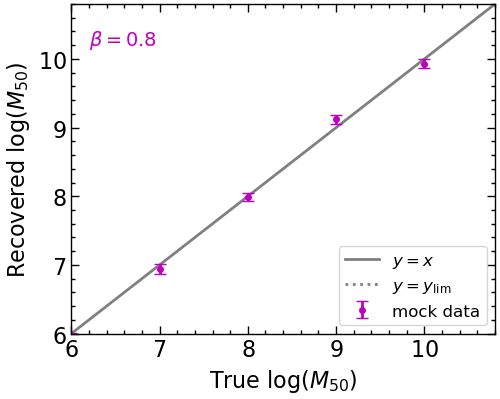

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5.2, 4.2))

ax.plot([5, 11], [5, 11], lw=2, color='gray', zorder=-10, label=r'$y=x$')

ax.axhline((y_lim - yp)/beta_true + xp, color='gray', linestyle='dotted', label=r'$y=y_{\rm{lim}}$')

ax.errorbar(x50_true, x50_out_med, yerr=np.abs(np.array([x50_out_hi-x50_out_med, x50_out_med-x50_out_lo])),
           color='m', marker='o', capsize=4, linestyle='none', markersize=4, label='mock data')

#ax.scatter(x50_true, x50_out_med, color='k')

ax.set_ylabel(r'Recovered $\log(M_{50})$')
ax.set_xlabel(r'True $\log(M_{50})$')

ax.text(6.2, 10.2, rf'$\beta = {beta_true}$', fontsize=14, color='m')


ax.set_xlim(6, 10.8)
ax.set_ylim(6, 10.8)

ax.legend(loc=4, fontsize=12, frameon=True)

fig.tight_layout()
fig.savefig('BHOFmock.pdf', dpi=300)

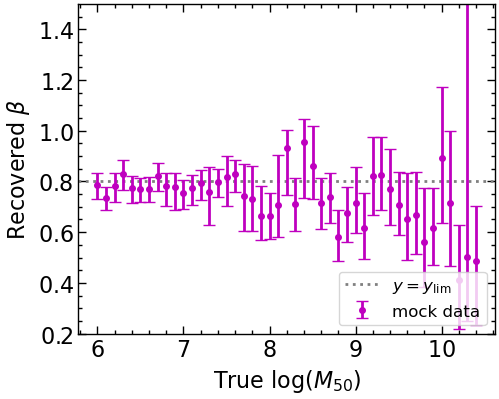

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5.2, 4.2))

#ax.plot([5, 11], [5, 11], lw=2, color='gray', zorder=-10, label=r'$y=x$')

beta_trues = np.full_like(beta_out_med, beta_true)

ax.axhline(beta_true, color='gray', linestyle='dotted', label=r'$y=y_{\rm{lim}}$')

ax.errorbar(x50_true, beta_out_med, yerr=np.abs(np.array([beta_out_hi-beta_out_med, beta_out_med-beta_out_lo])),
           color='m', marker='o', capsize=4, linestyle='none', markersize=4, label='mock data')

#ax.scatter(x50_true, x50_out_med, color='k')

ax.set_ylabel(r'Recovered $\beta$')
ax.set_xlabel(r'True $\log(M_{50})$')

#ax.text(6.2, 10.2, rf'$\beta = {beta_true}$', fontsize=14, color='m')

#ax.set_xlim(0, 1)
ax.set_ylim(0.2, 1.5)

ax.legend(loc=4, fontsize=12, frameon=True)

fig.tight_layout()
fig.savefig('betamock.pdf', dpi=300)

x_{50} should be well constrained above the dotted line, but consistent with y=x everywhere, even below the dotted line.

Something is wrong with how I am integrating through the upper limits or something.